## Libraries used

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import yfinance as yf
import torch
from sklearn.model_selection import train_test_split

from einops import rearrange
from gluonts.dataset.multivariate_grouper import MultivariateGrouper
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split
#from gluonts.dataset.util import to_pandas

from uni2ts.eval_util.plot import plot_single, plot_next_multi
from uni2ts.model.moirai import MoiraiForecast, MoiraiModule
from uni2ts.model.moirai_moe import MoiraiMoEForecast, MoiraiMoEModule

from tqdm import tqdm
from datetime import date
import re
import os
import xlsxwriter

/home/akn/miniconda3/envs/uni/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data import from yahoo finance

In [2]:
symbol = ['GC=F', 'CL=F', '^GSPC']
df = pd.DataFrame()
for sy in symbol:
    data = yf.download(sy, 
                start='2000-12-31', 
                end='2025-05-01', 
                progress=False,
    )['Close']
    data = data.resample("ME").mean().ffill()
    data = data[sy].rename('Value').to_frame()
    data['item_id'] = sy
    df = pd.concat([df, data], axis=0)
data = df.reset_index()
data.rename(columns={'Date': 'Report Time'}, inplace=True)
data

YF.download() has changed argument auto_adjust default to True


,Report Time,Value,item_id
0,2001-01-31,265.371427,GC=F
1,2001-02-28,261.805263,GC=F
2,2001-03-31,262.290907,GC=F
3,2001-04-30,261.079997,GC=F
4,2001-05-31,272.077272,GC=F
...,...,...,...
871,2024-12-31,6010.908552,^GSPC
872,2025-01-31,5979.515527,^GSPC
873,2025-02-28,6038.689967,^GSPC
874,2025-03-31,5683.983352,^GSPC


In [3]:
data_index = data[
                    ['item_id']
                                ].drop_duplicates().reset_index(drop=True)
data_index                               

,item_id
0,GC=F
1,CL=F
2,^GSPC


## Salesforce - Moirai model

In [4]:
TEST = 12
PDT = 12 # prediction length: any positive integer
CTX = 200  # context length: any positive integer
PSZ = "auto"  # patch size: choose from {"auto", 8, 16, 32, 64, 128}
BSZ = 1  # batch size: any positive integer

MODEL = "moirai"  # model name: choose from {'moirai', 'moirai-moe'}

SIZE = "large"

In [5]:
def moirai_BT(ds, test_data):
    # Prepare model
    if MODEL == "moirai":
        model = MoiraiForecast(
            module=MoiraiModule.from_pretrained(f"Salesforce/moirai-1.1-R-{SIZE}"),
            prediction_length=PDT,
            context_length=CTX,
            patch_size=PSZ,
            num_samples=100,
            target_dim=1,
            feat_dynamic_real_dim=ds.num_feat_dynamic_real,
            past_feat_dynamic_real_dim=ds.num_past_feat_dynamic_real,
        )
    elif MODEL == "moirai-moe":
        model = MoiraiMoEForecast(
            module=MoiraiMoEModule.from_pretrained(f"Salesforce/moirai-moe-1.0-R-{SIZE}"),
            prediction_length=PDT,
            context_length=CTX,
            patch_size=16,
            num_samples=100,
            target_dim=1,
            feat_dynamic_real_dim=ds.num_feat_dynamic_real,
            past_feat_dynamic_real_dim=ds.num_past_feat_dynamic_real,
        )

    predictor = model.create_predictor(batch_size=BSZ)
    forecasts = predictor.predict(test_data.input)

    input_it = iter(test_data.input)
    label_it = iter(test_data.label)
    forecast_it = iter(forecasts)

    return forecast_it 

In [6]:
def process(train_, target="Value", item_id="item_id", timestamp='Report Time', freq='M'): 

    ds = PandasDataset.from_long_dataframe(train_, target=target, item_id=item_id, timestamp=timestamp, freq=freq)

    # Split into train/test set & assign last TEST time steps as test set
    train, test_template = split(ds, offset=-TEST)
    
    # Construct rolling window evaluation
    test_data = test_template.generate_instances(
    prediction_length=PDT,  # number of time steps for each prediction
    windows=TEST // PDT,  # number of windows in rolling window evaluation
    distance=PDT,  # number of time steps between each window - distance=PDT for non-overlapping windows
    )

    forecast_it = moirai_BT(ds, test_data)

    return forecast_it

## Function definitions for result reporting

In [7]:
def error_metrics(predictions):
    # MAPE
    grouped = predictions.groupby('item_id')['APE'].agg(["mean", "std"])
    predictions = predictions.merge(grouped, on='item_id', suffixes=('', '_agg'))
    predictions.rename(columns={"mean": "MAPE", "std": "MAPE_std"}, inplace=True)
    mape_list = predictions["MAPE"].tolist()
    mape_std_list = predictions["MAPE_std"].tolist()

    # sMAPE
    grouped = predictions.groupby('item_id')['sAPE'].agg(["mean", "std"])
    predictions = predictions.merge(grouped, on='item_id', suffixes=('', '_agg'))
    predictions.rename(columns={"mean": "sMAPE", "std": "sMAPE_std"}, inplace=True)
    smape_list = predictions["sMAPE"].tolist()
    smape_std_list = predictions["sMAPE_std"].tolist()

    # MSE
    grouped = predictions.groupby('item_id')['SE'].agg(["mean", "std"])
    predictions = predictions.merge(grouped, on='item_id', suffixes=('', '_agg'))
    predictions.rename(columns={"mean": "MSE", "std": "MSE_std"}, inplace=True)
    mse_list = predictions['MSE'].tolist()
    mse_std_list = predictions['MSE_std'].tolist()

    # MAE
    grouped = predictions.groupby('item_id')['AE'].agg(["mean", "std"])
    predictions = predictions.merge(grouped, on='item_id', suffixes=('', '_agg'))
    predictions.rename(columns={"mean": "MAE", "std": "MAE_std"}, inplace=True)
    mae_list = predictions['MAE'].tolist()
    mae_std_list = predictions['MAE_std'].tolist()

    return predictions, mape_list, smape_list, mse_list, mae_list

In [8]:
def result(forecast_it, train_df):
    all_preds = list()
    for item in forecast_it:
        
        family = item.item_id
        p = item.samples.mean(axis=0)
        p10 = np.percentile(item.samples, 10, axis=0)
        p90 = np.percentile(item.samples, 90, axis=0)
        dates = pd.date_range(start=item.start_date.to_timestamp(), periods=len(p), freq='ME')
        family_pred = pd.DataFrame({'Report Time': dates, 'item_id': family, 'Forecast': p, 'p10': p10, 'p90': p90})
        all_preds += [family_pred]

    all_preds = pd.concat(all_preds, ignore_index=True)
    
    all_preds = all_preds.merge(train_df, on=['Report Time', 'item_id'], how='left')

    all_preds["APE"] = abs( (all_preds['Value'] - all_preds['Forecast']) / all_preds['Value'] ) * 100

    eps = 1e-8  # small value to prevent division by zero
    all_preds['sAPE'] = 200 * (abs(all_preds['Forecast'] - all_preds['Value']) /
                                   (abs(all_preds['Forecast']) + abs(all_preds['Value']) + eps))

    all_preds['SE'] = ((all_preds['Forecast'] - all_preds['Value']) ** 2)

    all_preds['AE'] = abs(all_preds['Forecast'] - all_preds['Value'])

    result, mape_list, smape_list, mse_list, mae_list = error_metrics(all_preds)

    return result, [mape_list[0], mape_list[12], mape_list[24]], [smape_list[0], smape_list[12], smape_list[24]], [mse_list[0], mse_list[12], mse_list[24]], [mae_list[0], mae_list[12], mae_list[24]]  

In [9]:
def error_fig(results, item, mypath, metric):
    mean = float(round((results).mean(), 2))
    std = float(round(np.std(results), 2))

    # Plotting the line plot using matplotlib
    plt.figure(figsize=(11.86, 3.6))
    plt.plot(results, marker='o')
    plt.title(f"{item} - Overall Mean={mean} & Std. deviation={std} of {metric} for 2 year Walk foreward Back-test")
    plt.xlabel('Period')
    plt.ylabel(f'{metric}')
    plt.grid(True)

    # Saving the plot as an image without displaying it
    plt.savefig(f"{mypath}_{metric}.png", dpi=200)

    return mean, std

## Train-test split

In [10]:
# Perform train-test split for each item_id
train_list = []
test_list = []

for item_id in data['item_id'].unique():
    item_df = data[data['item_id'] == item_id]
    train_df, test_df = train_test_split(item_df, test_size=13, shuffle=False)
    train_list.append(train_df)
    test_list.append(test_df)

train_df = pd.concat(train_list)
test_df = pd.concat(test_list)

## Model Backtesting

In [11]:
path = "/mnt/d/BT/uni2ts/Gold_WTI_SP500"

workbook = xlsxwriter.Workbook(f"{path}/Results.xlsx")
workbook.close()

unique_dates = test_df['Report Time'].unique()
len(unique_dates)

Mape_dic= {}
sMape_dic = {}
Mse_dic = {} 
Mae_dic = {} 

i=1
for date in unique_dates:
    
    rows_to_append = test_df[test_df['Report Time'] == date]
    train_df = pd.concat([train_df, rows_to_append])
    test_df = test_df.drop(rows_to_append.index)

    forecast_it = process(train_df.copy())

    Result, Mape_dic[i], sMape_dic[i], Mse_dic[i], Mae_dic[i] = result(forecast_it, train_df.copy())

    with pd.ExcelWriter(f"{path}/Results.xlsx", mode="a", engine="openpyxl") as writer:
        Result.to_excel(writer, sheet_name=f'{i}', index=False)

    i+=1

## Result in teams of MAPE

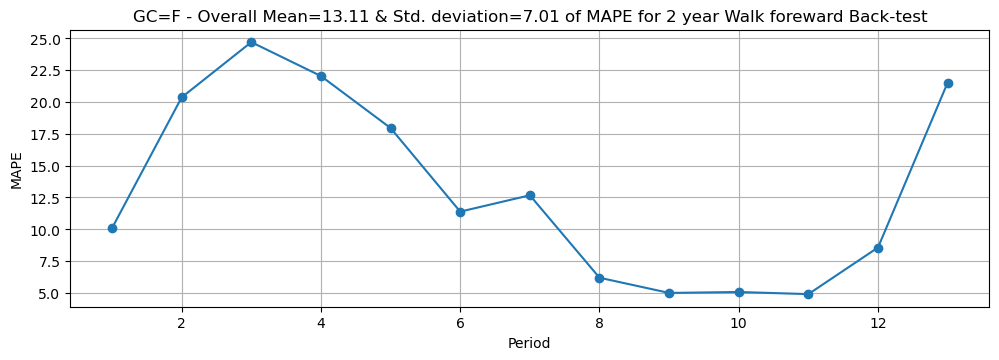

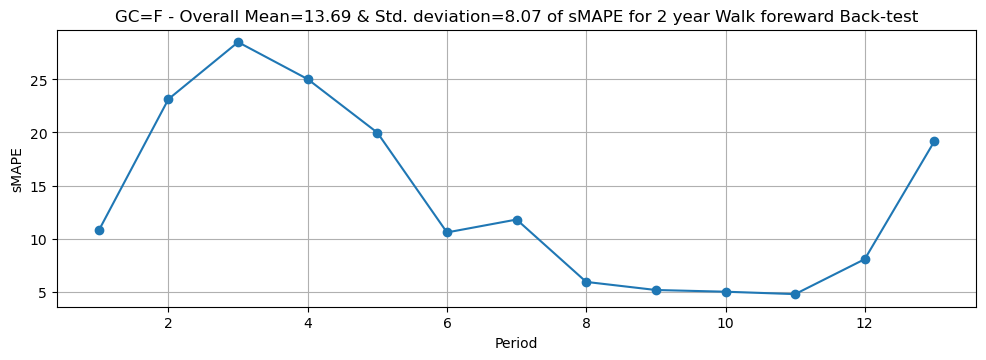

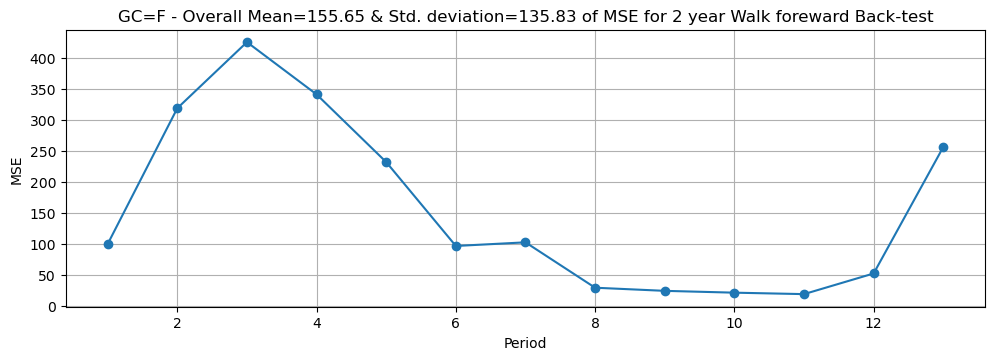

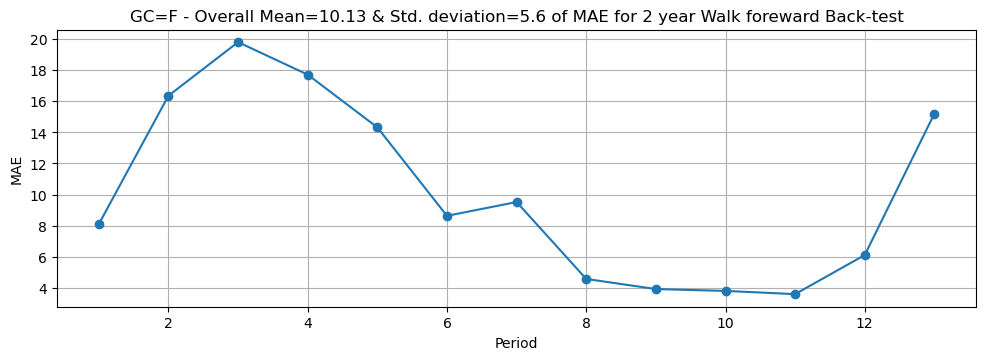

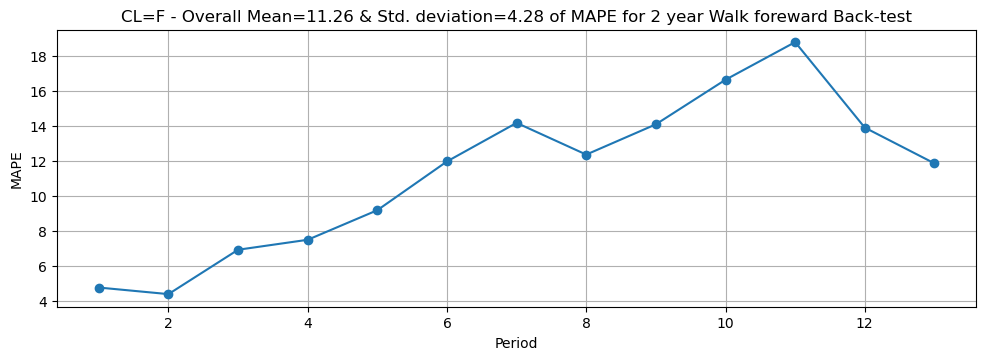

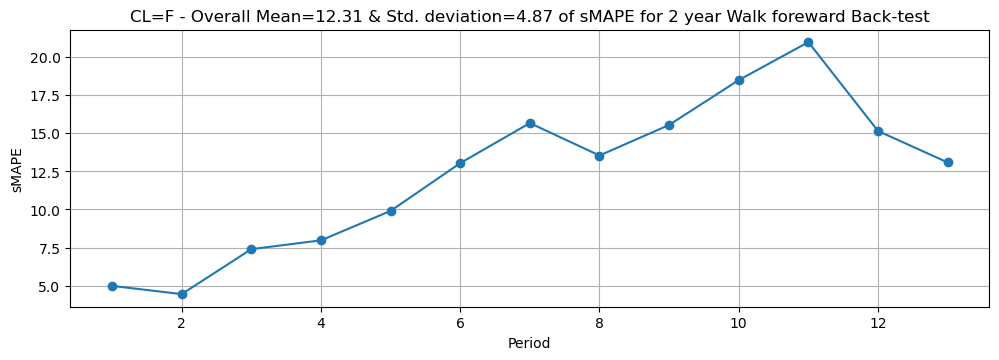

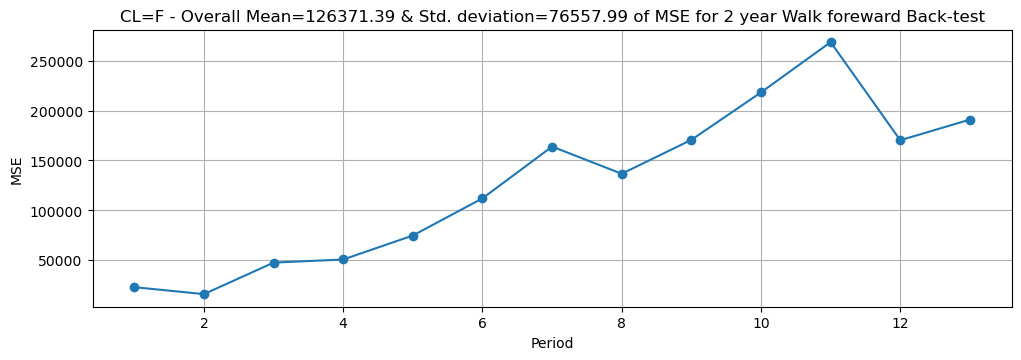

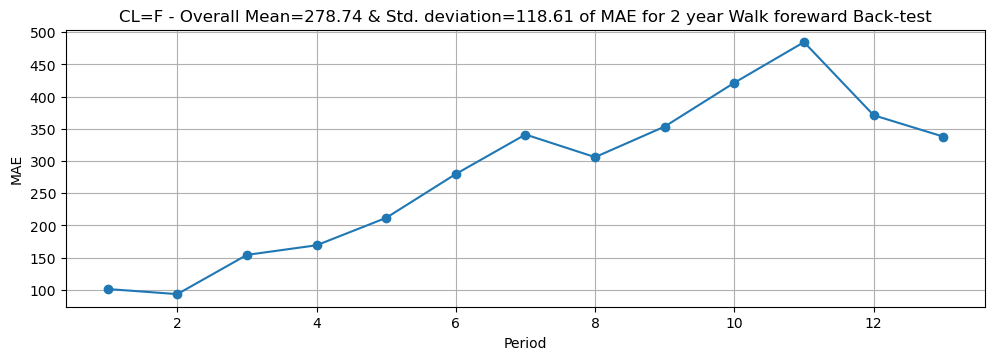

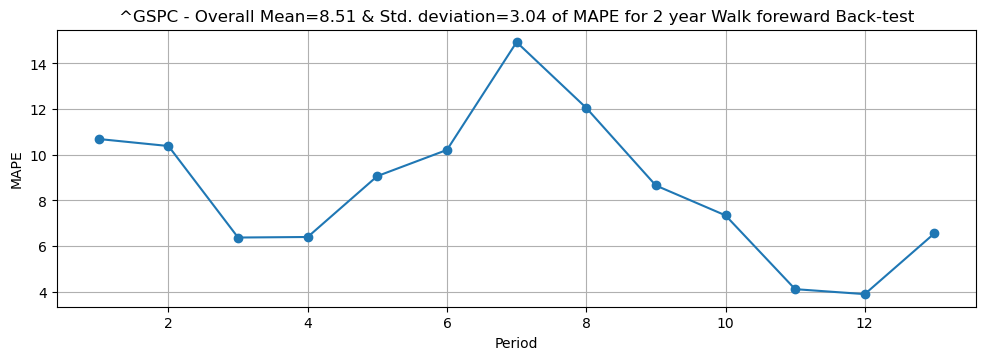

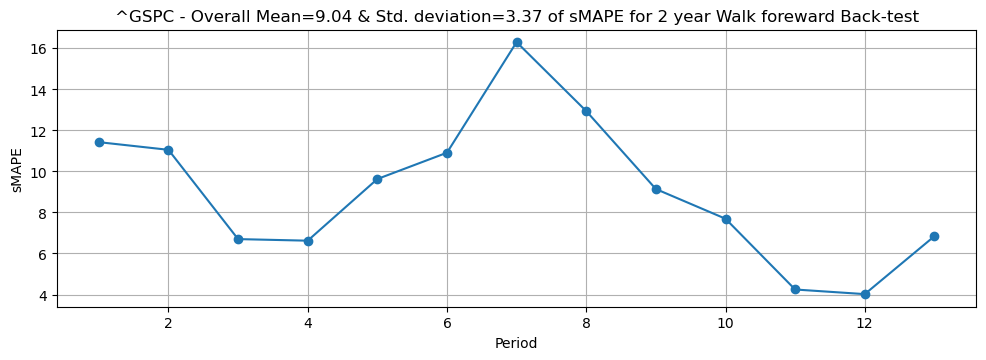

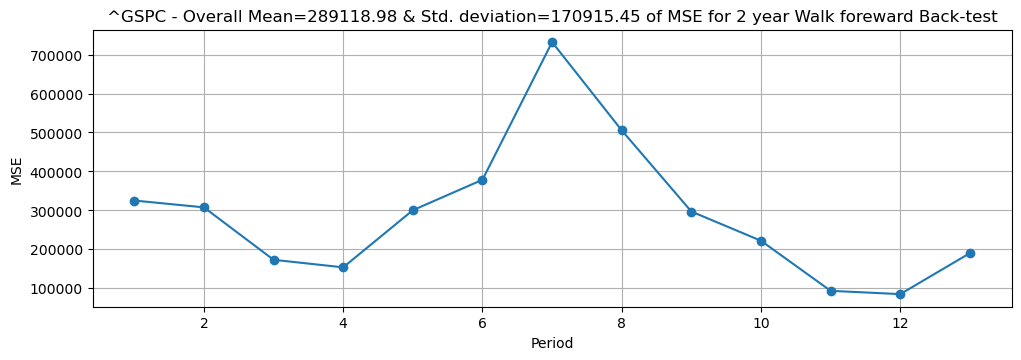

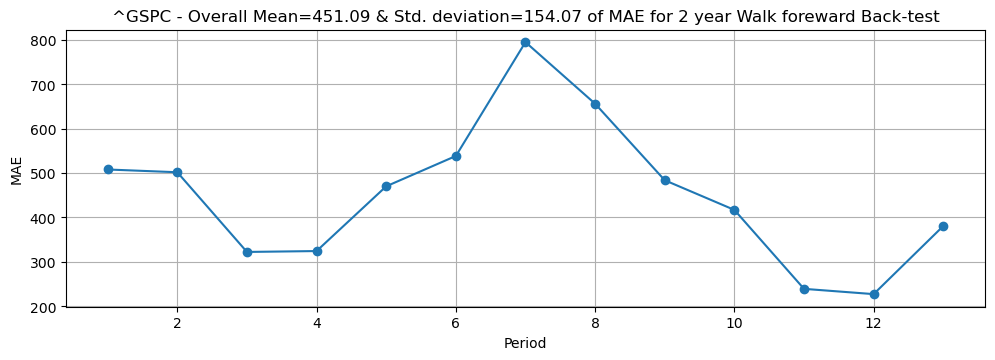

In [12]:
dic = {
    'Item':[],
    'Avg. MAPE':[],
    'Std.Dev. of Avg. MAPE':[],
    'Avg. sMAPE':[],
    'Std.Dev. of Avg. sMAPE':[],
    'Avg. MSE':[],
    'Std.Dev. of Avg. MSE':[],
    'Avg. MAE':[],
    'Std.Dev. of Avg. MAE':[],
       }
BTinfo = pd.DataFrame(dic)

mape_df = pd.DataFrame(Mape_dic, index=data['item_id'].unique()).transpose()
smape_df = pd.DataFrame(sMape_dic, index=data['item_id'].unique()).transpose()
mse_df = pd.DataFrame(Mse_dic, index=data['item_id'].unique()).transpose()
mae_df = pd.DataFrame(Mae_dic, index=data['item_id'].unique()).transpose()

os.makedirs(f'{path}/error_images', exist_ok=True)

for ind in data_index.index:
    item = data_index['item_id'][ind]
    mypath = f'{path}/error_images/{item}'

    mape_mean, mape_std = error_fig(mape_df[item], item, mypath, 'MAPE')
    smape_mean, smape_std = error_fig(smape_df[item], item, mypath, 'sMAPE')
    mse_mean, mse_std = error_fig(mse_df[item], item, mypath, 'MSE')
    mae_mean, mae_std = error_fig(mae_df[item], item, mypath, 'MAE')

    bt_list = []
    bt_list.insert(0, data_index['item_id'][ind])
    bt_list.insert(1, mape_mean)
    bt_list.insert(2, mape_std)
    bt_list.insert(3, smape_mean)
    bt_list.insert(4, smape_std)
    bt_list.insert(5, mse_mean)
    bt_list.insert(6, mse_std)
    bt_list.insert(7, mae_mean)
    bt_list.insert(8, mae_std)
        
    BTinfo.loc[ind] = bt_list
    
BTinfo.to_excel(f'{path}/BTinfo.xlsx', index=False)